## POVM RNN

Michael Albergo

Pauli-4 TFIM data. Datafile is named "numpy_POVM_data.npz"

RNN Model includes sampler, used later for visualization. Hyperparameters defined in cell 3 other than learning rate

In [1]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import os
import datetime
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import palettable
import seaborn as sns

In [2]:
device = torch.device("cuda:0" if torch.cuda.device_count() != 0 else "cpu")
print(device)

n_qubits = 50
n_outcomes =4
batchSize =40
hidden_size = 100
num_gru_layers = 2
filename = 'train.txt'
num_epochs = 50
log_interval = 100
loss_by_step = True
lr = 0.001

cpu


In [3]:
data_array = np.load('data/numpy_POVM_data.npz')['a']
print(data_array.shape)

(1000000, 200)


In [4]:
# TAKE A LOOK AT WHAT YOUR INPUT DATA LOOKS LIKE, I AM PRINTING THE FIRST ROW (FIRST SAMPLE OF 50 QUBITS)
# I THEN RESHAPE THEM SO EVERY 4 VALUES, WHICH REPRESENT ONE QUBITS OUTCOME MEASUREMENT, APPENDED INTO 50 ROWS
# PER SAMPLE. SO NOW THE DATA IS OF THE SHAPE [n_samples x n_qubits x n_outcomes]
#print(data_array[0])
reshaped_array = np.empty((1000000, 50, 4))
for i in range(data_array.shape[0]):
    reshaped_array[i] = data_array[i].reshape((50,4))
#print(reshaped_array[0]) 

In [5]:
# I LOAD THE DATA INTO A PYTORCH DATALOADER CLASS

tensor_array_train = torch.stack([torch.Tensor(i).double() for i in reshaped_array[:100000]])
tensor_data_train = torch.utils.data.TensorDataset(tensor_array_train)
tensor_array_test = torch.stack([torch.Tensor(i).double() for i in reshaped_array[100000:200000]])
tensor_data_test = torch.utils.data.TensorDataset(tensor_array_test)

train_loader = torch.utils.data.DataLoader(tensor_data_train, batch_size=batchSize, num_workers=1)
test_loader = torch.utils.data.DataLoader(tensor_data_test, batch_size = batchSize, num_workers = 1)
print(train_loader)

In [6]:
# I BUILD THE MODEL, WITH FUNCTIONS FOR INITIALIZING THE HIDDEN STATE AND THE INITIAL X
class RNN(nn.Module):
    def __init__(self, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_gru_layers
        self.steps = n_qubits
        self.n_outcomes = n_outcomes
        self.loss_by_step = loss_by_step
        self.batchSize = batchSize

        
        self.rnn = nn.GRU(n_outcomes, hidden_size, num_layers=self.num_layers, dropout=0.01)
        self.outcome = nn.Linear(hidden_size, n_outcomes)
        self.outcome2 = nn.Linear(n_outcomes, n_outcomes)
        self.CE = nn.CrossEntropyLoss()
        
        
    
    def initHidden(self):
        
        '''
        must be shape 
        [self.num_layers * num_directions (1 in this case), batchSize, hidden_size]
        '''
        return torch.ones(1*self.num_layers, batchSize, self.hidden_size).to(device).double()
    
    def initX(self):
        '''
        must be shape 
        [(1 step), batchSize, hidden_size]
        '''
        return torch.ones(1, batchSize, self.n_outcomes).to(device).double()
    

    def step(self, input, hidden=None):
        
        output, hidden = self.rnn(input, hidden)
        for_prediction = output.squeeze(0).to(device)
        outcome = F.softmax(self.outcome(for_prediction), dim = 1)
        return output, hidden, outcome

    
    
    def forward(self, inputs, hidden=None, force=True, steps=50):
        
        '''
        must be shape
        input: [length_sequence (n_qubits), batchSize, num_features (n_outcomes)]
        hidden: [num_layers * num_directions, batchSize, hidden_size]'''
        
        if force or steps == 0: steps = len(inputs)
        outputs = torch.zeros(steps, batchSize, hidden_size).double().to(device)
        outcome_probs = torch.zeros(steps, batchSize, n_outcomes).double().to(device)
        losses = torch.tensor(0).double().to(device)

        for i in range(steps):
            if hidden is None and i == 0:
                hidden = self.initHidden()
                input = self.initX()
                inputX = input
                targets = torch.argmax(inputs[i],dim=1)
            else:
                input = inputs[i].unsqueeze(0)
                targets = torch.argmax(inputs[i],dim=1)
                
            #evidence 
                
            output, hidden, outcome = self.step(input, hidden)
            if self.loss_by_step == True:
                #loss_i = self.CE(outcome, targets.long())
                #loss_i = self.step_loss(targets, outcome)
                loss_i = self.myCrossEntropyLoss(outcome, targets)
                losses = losses + loss_i
            outputs[i] = output
            outcome_probs[i] = outcome
            
        if loss_by_step == False:
            losses = self.loss_overall(inputs, outcome_probs)
            
        return outputs, hidden, outcome_probs, losses, inputX
       


    def step_loss(self, real_outcomes, predicted_outcomes, ce = True):
    
        if ce is True:
            loss = F.cross_entropy(predicted_outcomes, real_outcomes.long(), size_average=False)
        else:
            one_hot_Trueoutcomes = torch.zeros((real_outcomes.shape[0], real_outcomes.max()+1))
            one_hot_Trueoutcomes[torch.arange(real_outcomes.shape[0]).long(),real_outcomes.long()] = 1
            loss = F.mse_loss(one_hot_Trueoutcomes.to(device).double(), predicted_outcomes, size_average=False)
        return loss
    
    def myCrossEntropyLoss(self, outputs, labels):
        batch_size = outputs.size()[0]            # batch_size
        outputs = torch.log(outputs)   # compute the log of softmax values
        outputs = outputs[range(batch_size), labels] # pick the values corresponding to the labels
        return -torch.sum(outputs)/batch_size

    def loss_overall(self, real_outcomes, predicted_outcomes, ce = True):
    
        if ce is True:
           # CE = F.cross_entropy(real_outcomes[1:], predicted_outcomes[:-1], size_average=False)
            real_outcomes_1 = real_outcomes.view(batchSize*self.steps,4)
            target_labels = torch.argmax(real_outcomes_1,dim=1).long()
            predictions = predicted_outcomes.view(batchSize*self.steps,4)
            
            # take cross entropy between the output prediction and the true target label.
            loss = F.cross_entropy(predictions, target_labels, size_average=False)
        else:
            loss = F.mse_loss(real_outcomes, predicted_outcomes, size_average=False)

        return loss
    
    def sample(self):
    
        #initialize hidden as in model
        hidden = self.initHidden()
        inputX = self.initX()
        samples = torch.zeros(self.steps, self.batchSize, self.n_outcomes)

        for i in range(self.steps):

            #initialize for one-hot encoding, qubit_i_samples will be a class chosen for each batch entry based on probabilities
            # batchSize number of samples for ith qubit
            qubit_i_samples = torch.zeros(self.batchSize)
            #eventually the one hot encoded samples for the ith qubit, num_samples = batchSize
            sample_i = torch.zeros(self.batchSize, self.n_outcomes)
            if i == 0:
                output, hidden, outcome = self.step(inputX, hidden)
                qubit_i_probs = outcome.to('cpu').data.numpy()
            elif i > 0:
                self.step(sample_i.unsqueeze(0).to(device).double(), hidden)

            for batch_entry in range(self.batchSize):
                #implemented w numpy because simpler, no random.choice in torch
                qubit_i_samples[batch_entry] = torch.from_numpy(np.random.choice([0,1,2,3], size = 1, p=qubit_i_probs[batch_entry]))
            sample_i[torch.arange(qubit_i_samples.shape[0]).long(), qubit_i_samples.long()] = 1
            #print(sample_i)

            samples[i] = sample_i

        return samples
    

    
model = RNN(hidden_size).to(device).double()
optimizer = optim.Adam(model.parameters(), lr=lr)
    
    

In [7]:
train_losses = []
for epoch in range(1, num_epochs + 1):
    #train(epoch, train_losses)
    train_loss = 0
    for batch_idx, (data) in enumerate(train_loader,):
        data = data[0].to(device).permute(1,0,2)#.reshape(n_qubits, batchSize, n_outcomes)

        optimizer.zero_grad()
        outputs, hidden, outcome_probs, loss, inputX = model(data)
        loss.backward()
        
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data[1]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data[1]) ))
    avg_batch_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_batch_loss)

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, avg_batch_loss))

Train Epoch: 1 [0/100000 (0%)]	Loss: 1.750328
Train Epoch: 1 [4000/100000 (4%)]	Loss: 0.115239
Train Epoch: 1 [8000/100000 (8%)]	Loss: 0.029579


Process Process-1:
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/roger/.virtualenvs/pepinillo/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.fra

KeyboardInterrupt: 

In [11]:
## try sampling from it, compute average probability of each outcome
sample_test = model.sample()

# sigma_X = np.array([[0, 1], [1, 0]], dtype=np.complex128)
# sigma_Y = np.array([[0, -1.j], [1.j, 0]], dtype=np.complex128)
# sigma_Z = np.array([[1, 0], [0, -1]], dtype=np.complex128)


# Z = [np.array([1, 0], dtype=np.complex128), np.array([0, 1], dtype=np.complex128)]
# X1 = 1 / np.sqrt(2) * np.array([1, 1], dtype=np.complex128)
# X2 = 1 / np.sqrt(2) * np.array([1, -1], dtype=np.complex128)
# X = [X1, X2]
# Y1 = 1 / np.sqrt(2) * np.array([1, 1.j], dtype=np.complex128)
# Y2 = 1 / np.sqrt(2) * np.array

M0 = np.array([[1/3, 0], [0, 0]], dtype=np.complex128)
M1 = np.array([[0,   0], [0, 1/3]], dtype=np.complex128)
M2 = np.array([[1/6, 1/6], [1/6, 1/6]], dtype=np.complex128)
M3 = np.array([[0.5, -1/6], [-1/6, 0.5]], dtype=np.complex128)

M = [M0, M1, M2, M3]

T = np.array([[1, 1/2, 1/2, 1],
              [1/2, 1, 1/2, 1],
              [1/2, 1/2, 1, 1],
              [1, 1, 1, 6]], dtype=np.complex128)


TM = np.zeros((2, 2, 4), dtype=np.complex128)
for i in range(4):
    for j in range(4):
        TM[:, :, i] = T[i, j] * M[j]
        

rho = np.zeros(1<<50)

array([[[ 0.5       +0.j,  0.5       +0.j,  0.5       +0.j,
          3.        +0.j],
        [-0.16666667+0.j, -0.16666667+0.j, -0.16666667+0.j,
         -1.        +0.j]],

       [[-0.16666667+0.j, -0.16666667+0.j, -0.16666667+0.j,
         -1.        +0.j],
        [ 0.5       +0.j,  0.5       +0.j,  0.5       +0.j,
          3.        +0.j]]])

<Figure size 1080x72 with 0 Axes>

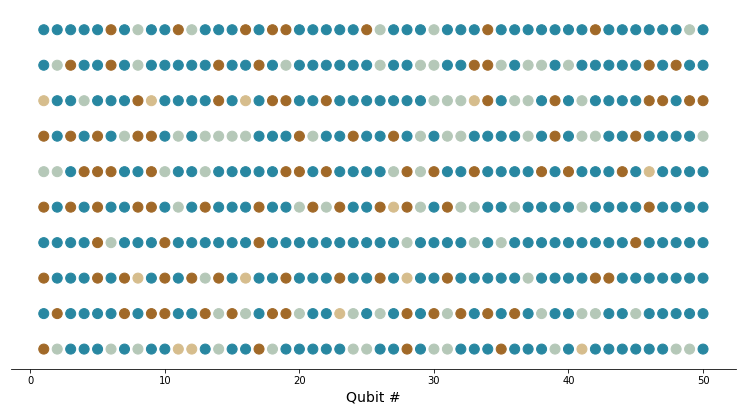

In [9]:
def plot_samples(sample_test = sample_test, n_samples = 1, n_qubits = n_qubits):
    qubits = np.arange(1, n_qubits + 1)
    color_labels = np.array([np.argmax(sample_test[:,i,:].cpu().data.numpy(), axis = 1) for i in range(batchSize)])#[0.456,0.962,0.231] 
    #print(color_labels[0].shape, qubits.shape)
    #UnlabelledY=[0,1,0]
    fig = plt.figure(figsize=(15,1))
    flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
    muted=["#4878CF", "#6ACC65", "#D65F5F",
               "#B47CC7", "#C4AD66", "#77BEDB"]
    #my_cmap = ListedColormap(sns.color_palette(muted).as_hex())
    #cmap = sns.cubehelix_palette(light=0.8, dark=0.4, start=0.03, rot=0.4, as_cmap=True)
    cmap = ListedColormap(palettable.cartocolors.diverging.Earth_4.mpl_colors)
    #cmap = ListedColormap(palettable.wesanderson.Chevalier_4.mpl_colors)
    #cmap = ListedColormap(palettable.wesanderson.Darjeeling2_5.mpl_colors)
    #cmap = ListedColormap(palettable.wesanderson.Moonrise2_4.mpl_colors)
    #cmap = ListedColormap(palettable.wesanderson.FantasticFox2_5.mpl_colors)
    print(cmap)
    
    if n_samples == 1:
        fig = plt.figure(figsize=(15,1))
        plt.scatter(qubits, np.zeros_like(qubits), 
                c=color_labels[0], cmap=cmap, vmin=0, s=120)
        #plt.axis('off')
        plt.xlabel("Qubit #", fontsize=14)
    else:
        fig, axes = plt.subplots(n_samples, 1, figsize=(13,n_samples * 0.66))
        fig.subplots_adjust(hspace=-0.1)
        for i in range(n_samples):
            axes[i].scatter(qubits, np.zeros_like(qubits), 
                    c=color_labels[i], cmap=cmap, vmin=0, s=100)
            axes[i].set_yticks([])
            sns.despine(left=True, bottom=True)
            #sns.despine(bottom=True)
            #sns.despine(top=True)
            if i == n_samples - 1:
                axes[i].set_xlabel("Qubit #", fontsize=14)
                axes[i].spines["bottom"].set_visible(True)
            else:
                axes[i].set_xticks([])

    plt.show()
    return

plot_samples(sample_test = sample_test, n_samples = 10, n_qubits = 50)


In [34]:
M0 = np.array([[1 / 3, 0], [0, 0]], dtype=np.complex128)
M1 = np.array([[0    , 0], [0, 1/3]], dtype=np.complex128)
M2 = np.array([[1 / 6, 1 / 6], [1 / 6, 1/ 6]], dtype=np.complex128)
M3 = np.array([[0.5 , -1/6], [-1/6, 0.5]], dtype=np.complex128)

M = [M0, M1, M2, M3]


def overlap_matrix(M):
    T = np.zeros((len(M), len(M)), dtype=np.complex128)
    for i in range(len(M)):
        for j in range(len(M)):
            T[i, j] = np.trace(np.matmul(M[i], M[j]))
    return T


# T = overlap_matrix(M)

T = np.array([
    [1, 0.5, 0.5, 1],
    [0.5, 1, 0.5, 1],
    [0.5, 0.5, 1, 1],
    [1, 1, 1, 6]])
T_inv = np.linalg.inv(T)


T_M = []
for i in range(4):
    for j in range(4):
        T_M.append(T_inv[i, j] * M[j])

T_M

[array([[0.51851852+0.j, 0.        +0.j],
        [0.        +0.j, 0.        +0.j]]),
 array([[-0.        +0.j, -0.        +0.j],
        [-0.        +0.j, -0.14814815+0.j]]),
 array([[-0.07407407+0.j, -0.07407407+0.j],
        [-0.07407407+0.j, -0.07407407+0.j]]),
 array([[-0.05555556+0.j,  0.01851852-0.j],
        [ 0.01851852-0.j, -0.05555556+0.j]]),
 array([[-0.14814815+0.j, -0.        +0.j],
        [-0.        +0.j, -0.        +0.j]]),
 array([[0.        +0.j, 0.        +0.j],
        [0.        +0.j, 0.51851852+0.j]]),
 array([[-0.07407407+0.j, -0.07407407+0.j],
        [-0.07407407+0.j, -0.07407407+0.j]]),
 array([[-0.05555556+0.j,  0.01851852-0.j],
        [ 0.01851852-0.j, -0.05555556+0.j]]),
 array([[-0.14814815+0.j, -0.        +0.j],
        [-0.        +0.j, -0.        +0.j]]),
 array([[-0.        +0.j, -0.        +0.j],
        [-0.        +0.j, -0.14814815+0.j]]),
 array([[0.25925926+0.j, 0.25925926+0.j],
        [0.25925926+0.j, 0.25925926+0.j]]),
 array([[-0.05555556+0

In [10]:
#batchSize = 50
#batchSize = 100
index = np.random.randint(0,len(data_array))
test = reshaped_array[index:index+batchSize]
data = torch.from_numpy(test).double().to(device)
#print(data.shape)
#print(inputX.shape)
#print(hidden.shape)

#output, hidden, outcome, loss, inputX = model(data)

def sample(model, n_qubits, batchSize = batchSize, hidden_size = hidden_size, n_outcomes = n_outcomes, num_layers = num_gru_layers):
    
    #initialize hidden as in model
    hidden = torch.ones(1*num_layers, batchSize, hidden_size).to(device).double()
    initX = torch.ones(1, batchSize, n_outcomes).to(device).double()
    samples = torch.zeros(n_qubits, batchSize, n_outcomes)
    
    for i in range(n_qubits):
        
        #initialize for one-hot encoding, qubit_i_samples will be a class chosen for each batch entry based on probabilities
        # batchSize number of samples for ith qubit
        qubit_i_samples = torch.zeros(batchSize)
        #eventually the one hot encoded samples for the ith qubit, num_samples = batchSize
        sample_i = torch.zeros(batchSize,n_outcomes)
        if i == 0:
            output, hidden, outcome = model.step(inputX, hidden)
            qubit_i_probs = outcome.to('cpu').data.numpy()
        elif i > 0:
            model.step(sample_i.unsqueeze(0).to(device).double(), hidden)
            
        for batch_entry in range(batchSize):
            qubit_i_samples[batch_entry] = torch.from_numpy(np.random.choice([0,1,2,3], size = 1, p=qubit_i_probs[batch_entry]))
        sample_i[torch.arange(qubit_i_samples.shape[0]).long(), qubit_i_samples.long()] = 1
        #print(sample_i)
 
        samples[i] = sample_i
    
    return samples
            
sample_test = sample(model, n_qubits)  

#compare probabilities:
print(sample_test.shape)
bin_counts = [np.bincount(np.argmax(sample_test[:,i,:].cpu().data.numpy(), axis = 1)) for i in range(batchSize) ]
print((np.array(bin_counts).mean(0) / np.array(bin_counts).mean(0).sum()))
print(np.array(bin_counts).mean(0))

torch.Size([50, 40, 4])
[0.152  0.0215 0.153  0.6735]
[ 7.6    1.075  7.65  33.675]


In [11]:
counts = []
for i in range(len(data_array)):
    #print(np.argmax(data_array[i]).shape)
    count = np.bincount(np.argmax(reshaped_array[i], axis=1))
    counts.append(count)
    #break
    #for j in range(len(data_array[i])):
       # print(data_array[i][j])  
   # if i == 50:
    #    break

In [ ]:
counts[:50]

In [9]:
means = np.array(counts).mean(0)
print(means)
print(means / (means.sum()))

nan
nan


/Users/roger/.virtualenvs/qucumber/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
/Users/roger/.virtualenvs/qucumber/lib/python3.6/site-packages/numpy-1.15.1-py3.6-macosx-10.13-x86_64.egg/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
## testing my own cross entropy

numpy = torch.from_numpy(reshaped_array[0])
labels = torch.argmax(numpy,dim=1)
numpy = torch.log(numpy)
numpy[0] = torch.log(torch.from_numpy(np.array([0.75,0.2,0,0.05])))
print(numpy)
print(labels)

NameError: name 'reshaped_array' is not defined

In [ ]:
output_vals = numpy[range(50), labels]
print(output_vals)

In [ ]:
sample_test[:,0,:].shape